In [2]:
import praw
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm_notebook
import psaw
import sklearn as skl
from sklearn import feature_extraction, pipeline
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download("stopwords")
nltk.download('punkt')

import sys
import unidecode
import functools
import spacy
spacy.prefer_gpu() #enable gpu
from word2number import w2n
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
sns.set_theme(style = "whitegrid")
pd.set_option("display.max_columns",None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yahoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [429]:
df_all["selftext"][0]

"My team includes Ted Ginn, Julian Edelman, and Josh Rosen. My team name is Ginn &amp; Jews. \n\nOne of my bosses, who is Jewish, says this is anti-Semitic. \n\nTry as I might, I just can't seem to wrap my head around that or how it is in any way derogatory.\n\nAm I the asshole?"

In [128]:
df_all = pd.read_csv("src/data/original_data/AITA_all.csv")
df_ass = pd.read_csv("src/data/original_data/AITA_ass.csv")
df_not = pd.read_csv("src/data/original_data/AITA_not.csv")

# check if df ass/not/all has deleted post if so remove
print("shape of df ass: "+str(df_ass.shape))
print("shape of df not: "+str(df_not.shape))
print("shape of df all: "+str(df_all.shape))

print("shape of df ass after removing samples of deleted post: "+str(df_ass[df_ass["selftext"] != "[deleted]"].shape))
print("shape of df not after removing samples of deleted post: "+str(df_not[df_not["selftext"] != "[deleted]"].shape))
print("shape of df all after removing samples of deleted post: "+str(df_all[df_all["selftext"] != "[deleted]"].shape))

# removing samples with no selftext (post is deleted)
df_ass = df_ass[df_ass["selftext"] != "[deleted]"]
df_not = df_not[df_not["selftext"] != "[deleted]"]
df_all = df_all[df_all["selftext"] != "[deleted]"]

df_ass.reset_index(drop = True, inplace = True)
df_not.reset_index(drop = True, inplace = True)
df_all.reset_index(drop=True, inplace = True)


# select samples from df_all that is either tagged as not a asshole or a asshole
mask = (df_all["link_flair_css_class"] == "not") | (df_all["link_flair_css_class"] == "ass")
df_all = df_all[mask]
df_all.reset_index(drop = True, inplace = True)
print("shape of df all with submissions tagged as either not a a*hole or a* hole")
print(df_all.shape)

shape of df ass: (4421, 33)
shape of df not: (10000, 33)
shape of df all: (16000, 33)
shape of df ass after removing samples of deleted post: (4043, 33)
shape of df not after removing samples of deleted post: (9409, 33)
shape of df all after removing samples of deleted post: (13758, 33)
shape of df all with submissions tagged as either not a a*hole or a* hole
(6503, 33)


In [549]:
# check if there are overlapping samples from df_all that is either in df_not or df_ass
df_meta = pd.concat([df_all, df_not, df_ass], axis = 0)
df_meta.reset_index(drop = True, inplace = True)

# number of post grouped by flairs (ass, not)
print(df_meta.drop_duplicates(ignore_index = False).groupby(["link_flair_css_class"]).count()["selftext"])

# update
df_meta.drop_duplicates(ignore_index = True, inplace = True)


# remove columns that are not needed
cols_toremove = ['created_utc', 'subreddit', 'author', 'domain', 'ups','downs', 'saved' , 'from_kind', 'gilded', 
                 'from', 'stickied','retrieved_on','thumbnail', 'subreddit_id', 'hide_score','is_self',
                 'from_id','name','author_flair_css_class', 'author_flair_text', 'quarantine', 'link_flair_text', 'distinguished']
df_meta.drop(columns = cols_toremove, inplace = True)
df_meta.head()

link_flair_css_class
ass    4043
not    9570
Name: selftext, dtype: int64


,url,num_comments,score,title,selftext,id,over_18,link_flair_css_class,archived,permalink
0,https://www.reddit.com/r/AmItheAsshole/comment...,33,12,AITA for my fantasy football league name?,"My team includes Ted Ginn, Julian Edelman, and...",cum4ob,False,ass,False,/r/AmItheAsshole/comments/cum4ob/aita_for_my_f...
1,https://www.reddit.com/r/AmItheAsshole/comment...,6,2,AITA for not properly greeting my neighbor?,Basically i was getting ready to leave my pare...,cum6kj,False,not,False,/r/AmItheAsshole/comments/cum6kj/aita_for_not_...
2,https://www.reddit.com/r/AmItheAsshole/comment...,10,0,AITA For implying what my boyfriend did was st...,We were reading a similar post on here about a...,cum7pp,False,ass,False,/r/AmItheAsshole/comments/cum7pp/aita_for_impl...
3,https://www.reddit.com/r/AmItheAsshole/comment...,8,2,WIBTA if I don’t help people on the streets out,"Ok so I love to help people, but sometimes idk...",cum9ae,False,not,False,/r/AmItheAsshole/comments/cum9ae/wibta_if_i_do...
4,https://www.reddit.com/r/AmItheAsshole/comment...,63,0,AITA For Reporting the Uber Driver,"It's simple, my.mother and her friends went to...",cumasq,False,ass,False,/r/AmItheAsshole/comments/cumasq/aita_for_repo...


# EDA
## word counts over all documents

In [573]:
df_meta["wordcounts"] = df_meta["selftext"].apply(lambda x: x.replace("\n","")).\
                    apply(lambda x: x.replace("&amp;#x200B;","")).\
                    apply(lambda x: x.replace("&amp;", "and")).\
                    apply(lambda x: len(x.split(" ")))

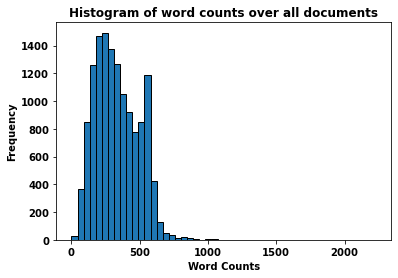

In [318]:
word_counts_per_doc = []
for selftxt in df_meta["selftext"]:
    selftxt = selftxt.replace("\n","")
    selftxt = selftxt.replace("&amp;#x200B;","")
    selftxt = selftxt.replace("&amp;", "and")
    
    word_counts_per_doc.append(len(selftxt.split(" ")))

plt.title("Histogram of word counts over all documents")
plt.hist(word_counts_per_doc, bins = 50, edgecolor = "black");
plt.xlabel("Word Counts")
plt.ylabel("Frequency");

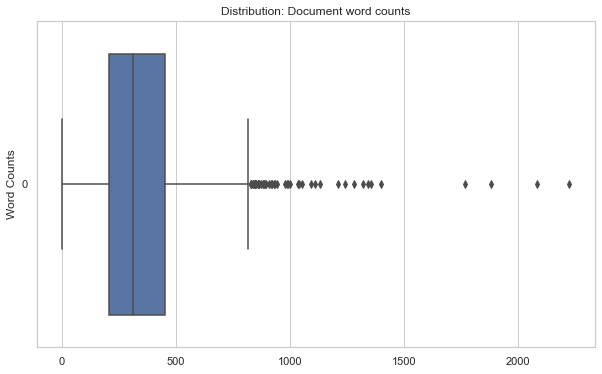

In [574]:
fig = plt.figure(num=1, figsize = (10,6))
sns.boxplot(data = word_counts_per_doc, orient = "h")
plt.title("Distribution: Document word counts")
plt.ylabel("Word Counts");

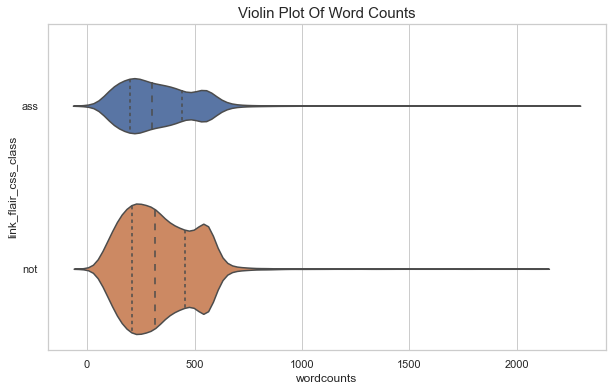

In [575]:
fig = plt.figure(num=1, figsize = (10,6))
plt.title("Violin plot of word counts".title(), fontsize = 15)
sns.violinplot( x = "wordcounts",y = "link_flair_css_class", data = df_meta, scale = "count", inner = "quartile", bw = 0.2);

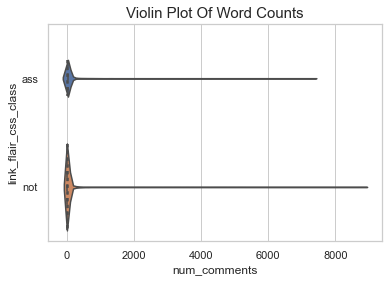

In [576]:
plt.title("Violin plot of word counts".title(), fontsize= 15)
sns.violinplot( x = "num_comments",y = "link_flair_css_class", data = df_meta, scale = "count", inner = "quartile");

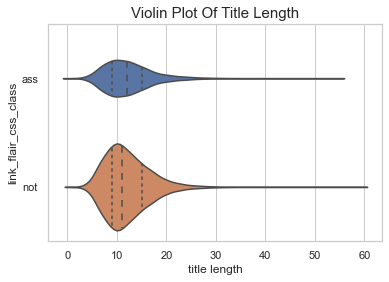

In [373]:
meta_copy = df_meta.copy()


meta_copy["title length"] = meta_copy["title"].apply(lambda x: len(x.split(" ")))
plt.title("Violin plot of title length".title(), fontsize = 15)

sns.violinplot(data= meta_copy, x = "title length", y = "link_flair_css_class", scale = "count", inner= "quartile");

## what stopwords are in nltk and spacy

In [577]:
nltk_stop_words = nltk_stopwords.words("english")
spacy_stop_words = nlp.Defaults.stop_words
print(set(nltk_stop_words) - spacy_stop_words) #only in nltk
print()
print( spacy_stop_words - set(nltk_stop_words))# only in spacy

{"mustn't", "you'll", 'didn', 'wasn', 's', 'couldn', 'ain', 'won', 'needn', "it's", 'isn', 'having', "haven't", "shouldn't", 'mightn', "isn't", "weren't", 'o', "shan't", "doesn't", 't', 'aren', "you'd", 'mustn', "aren't", "hasn't", 'hadn', "you've", 'm', 'shan', "couldn't", "you're", 'wouldn', 'don', "that'll", 'hasn', "wouldn't", "needn't", 'y', "should've", "she's", "won't", 've', 'theirs', 'll', 'ma', 'haven', 'weren', 'shouldn', "didn't", "mightn't", 'd', "don't", "wasn't", "hadn't", 'doesn'}

{'beyond', 'something', 'show', 'unless', 'seemed', 'everything', 'together', '‘ll', '’re', 'many', 'always', "'ll", 'hereupon', 'someone', 'part', 'nothing', 'whose', 'please', '’m', 'two', 'whereupon', 'though', 'elsewhere', 'meanwhile', 'formerly', 'seem', 'others', 'without', '‘s', 'sometimes', 'make', 'another', 'whereafter', 'would', 'twenty', '‘d', 'although', 'last', 'everywhere', 'moreover', 'eleven', 'whoever', 'used', 'regarding', 'thus', 'never', "'d", 'yet', 'third', 'n‘t', '’ll'

In [500]:
nlp = spacy.load("en_core_web_sm")
def pipeline_func(data, fns):
    """Pipeline function that applies all functions taken in to the data
    data: string data
    fns: list of functions
    
    ex: pipeline_func(data, [fn1, fn2, fn3])
    
    """
    
    return functools.reduce(lambda a,x: x(a), fns, data)



# prepare functions for pipeline
# step 1: change string to lowercase
def remove_newline(txt):
    """remove '/\n'"""
    return map(lambda x: x.replace("\n"," "), txt)
def remove_trip_space(txt):
    """remove triple spaces to single"""
    return map(lambda x: x.replace("   "," "), txt)

def remove_dub_space(txt):
    """remove double spaced made from remove_newline function"""
    return map(lambda x: x.replace("  "," "), txt)

def remove_amphex(txt):
    """remove ''&amp;#x200b' """
    return map(lambda x: x.replace("&amp;#x200B",""), txt)
def change_amp(txt):
    """remove '&amp;' """
    return map(lambda x: x.replace("&amp;","and"), txt)

def to_lower(txt):
    """returns lower case text"""
    return map(lambda x: x.lower(), txt)
def remove_accented_char(txt):
    """remove accented characters from text e.g. cafe`"""
    return map(lambda x: unidecode.unidecode(x), txt)

def remove_punc(txt):
    """remove punctuations"""
    return map(lambda x: re.sub("["+string.punctuation+"]", "", x), txt)

In [552]:
func_list = [remove_newline, remove_trip_space, remove_dub_space, remove_amphex,
             change_amp, to_lower, remove_accented_char, remove_punc]
df_meta["cleaned_txt_wo_punc"] =[cleaned_txt for cleaned_txt in pipeline_func(df_meta["selftext"].values, func_list)]

func_list = [remove_newline, remove_trip_space, remove_dub_space, remove_amphex,
             change_amp, to_lower, remove_accented_char]
df_meta["cleaned_txt_w_punc"] = [cleaned_txt for cleaned_txt in pipeline_func(df_meta["selftext"].values,func_list)]

In [553]:
df_meta.head()

,url,num_comments,score,title,selftext,id,over_18,link_flair_css_class,archived,permalink,cleaned_txt_wo_punc,cleaned_txt_w_punc
0,https://www.reddit.com/r/AmItheAsshole/comment...,33,12,AITA for my fantasy football league name?,"My team includes Ted Ginn, Julian Edelman, and...",cum4ob,False,ass,False,/r/AmItheAsshole/comments/cum4ob/aita_for_my_f...,my team includes ted ginn julian edelman and j...,"my team includes ted ginn, julian edelman, and..."
1,https://www.reddit.com/r/AmItheAsshole/comment...,6,2,AITA for not properly greeting my neighbor?,Basically i was getting ready to leave my pare...,cum6kj,False,not,False,/r/AmItheAsshole/comments/cum6kj/aita_for_not_...,basically i was getting ready to leave my pare...,basically i was getting ready to leave my pare...
2,https://www.reddit.com/r/AmItheAsshole/comment...,10,0,AITA For implying what my boyfriend did was st...,We were reading a similar post on here about a...,cum7pp,False,ass,False,/r/AmItheAsshole/comments/cum7pp/aita_for_impl...,we were reading a similar post on here about a...,we were reading a similar post on here about a...
3,https://www.reddit.com/r/AmItheAsshole/comment...,8,2,WIBTA if I don’t help people on the streets out,"Ok so I love to help people, but sometimes idk...",cum9ae,False,not,False,/r/AmItheAsshole/comments/cum9ae/wibta_if_i_do...,ok so i love to help people but sometimes idk ...,"ok so i love to help people, but sometimes idk..."
4,https://www.reddit.com/r/AmItheAsshole/comment...,63,0,AITA For Reporting the Uber Driver,"It's simple, my.mother and her friends went to...",cumasq,False,ass,False,/r/AmItheAsshole/comments/cumasq/aita_for_repo...,its simple mymother and her friends went to a ...,"it's simple, my.mother and her friends went to..."


In [579]:
nlp(df_meta["selftext"][0])

My team includes Ted Ginn, Julian Edelman, and Josh Rosen. My team name is Ginn &amp; Jews. 

One of my bosses, who is Jewish, says this is anti-Semitic. 

Try as I might, I just can't seem to wrap my head around that or how it is in any way derogatory.

Am I the asshole?

### remove stop words

'my team includes ted ginn julian edelman and josh rosen my team name is ginn and jews one of my bosses who is jewish says this is antisemitic try as i might i just cant seem to wrap my head around that or how it is in any way derogatory am i the asshole'

In [560]:
spacy_sw = nlp.Defaults.stop_words
nltk_sw = set(nltk.corpus.stopwords.words("english"))
meta_sw = spacy_sw | nltk_sw # merging stopwords from nltk and spacy

def remove_stopwords(txt, sw = meta_sw):
    """returns a string after removing stopwords"""
    words = tokenizer.tokenize(txt)
    return " ".join([word for word in words if not word in sw])

doc_sw = nlp(remove_stopwords(df_meta["cleaned_txt_w_punc"])) # doc w.o stop words
doc = nlp(" ".join(tokenized_txt)) # doc w stopwords
print(doc_sw)
print(doc)

team includes ted ginn julian edelman josh rosen team ginn jews bosses jewish says antisemitic try cant wrap head way derogatory asshole
my team includes ted ginn julian edelman and josh rosen my team name is ginn and jews one of my bosses who is jewish says this is antisemitic try as i might i just cant seem to wrap my head around that or how it is in any way derogatory am i the asshole


In [569]:
for w in nlp(df_meta["selftext"].values[0]).ents:
    print(w.text, w.label_)

Ted Ginn PERSON
Julian Edelman PERSON
Josh Rosen PERSON
Ginn & ORG
One CARDINAL
Jewish NORP
anti-Semitic NORP


In [535]:
doc_bin_wo_punc = spacy.tokens.DocBin() # docbins for doc w.o. punctuations and wo sw
doc_bin_w_punc = spacy.tokens.DocBin() # docbins for doc w punctuations and wo sw

doc_bin_wo_punc_sw = spacy.tokens.DocBin() # docbins for doc w.o. punctuations and w sw
doc_bin_w_punc_sw = spacy.tokens.DocBin() # docbins for doc w punctuations and w sw


doc = nlp(df_meta["cleaned_txt"].values[0])


In [533]:
for token in nlp(df_meta["selftext"].values[0]).ents:
    print(token, token.label_)

Ted Ginn PERSON
Julian Edelman PERSON
Josh Rosen PERSON
Ginn & ORG
One CARDINAL
Jewish NORP
anti-Semitic NORP


In [534]:
new_words

['my',
 'team',
 'includes',
 'ted',
 'ginn',
 'julian',
 'edelman',
 'and',
 'josh',
 'rosen',
 'my',
 'team',
 'name',
 'is',
 'ginn',
 'and',
 'jews',
 'one',
 'of',
 'my',
 'bosses',
 'who',
 'is',
 'jewish',
 'says',
 'this',
 'is',
 'anti',
 'semitic',
 'try',
 'as',
 'i',
 'might',
 'i',
 'just',
 'can',
 't',
 'seem',
 'to',
 'wrap',
 'my',
 'head',
 'around',
 'that',
 'or',
 'how',
 'it',
 'is',
 'in',
 'any',
 'way',
 'derogatory',
 'am',
 'i',
 'the',
 'asshole']

In [490]:

doc = nlp(piped_txt)
new_words = tokenizer.tokenize(piped_txt)
mytokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in doc]
tokens = [w2n.word_to_num(token.text) if token.pos_ == 'NUM' else token for token in doc]

In [491]:
new_words

['my',
 'team',
 'includes',
 'ted',
 'ginn',
 'julian',
 'edelman',
 'and',
 'josh',
 'rosen',
 'my',
 'team',
 'name',
 'is',
 'ginn',
 'and',
 'jews',
 'one',
 'of',
 'my',
 'bosses',
 'who',
 'is',
 'jewish',
 'says',
 'this',
 'is',
 'anti',
 'semitic',
 'try',
 'as',
 'i',
 'might',
 'i',
 'just',
 'can',
 't',
 'seem',
 'to',
 'wrap',
 'my',
 'head',
 'around',
 'that',
 'or',
 'how',
 'it',
 'is',
 'in',
 'any',
 'way',
 'derogatory',
 'am',
 'i',
 'the',
 'asshole']

In [489]:
tokenized = nltk.tokenize.word_tokenize(piped_txt)
tokens_wo_sw = [word for word in tokenized if not word in nlp.Defaults.stop_words]
tokens_wo_sw

['team',
 'includes',
 'ted',
 'ginn',
 'julian',
 'edelman',
 'josh',
 'rosen',
 'team',
 'ginn',
 'jews',
 'bosses',
 'jewish',
 'says',
 'anti',
 'semitic',
 'try',
 't',
 'wrap',
 'head',
 'way',
 'derogatory',
 'asshole']